## 第十週：主題模型（英文）

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以英文文本為示範<br>
<br>
這次課程分為四個部分：<br>
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. 建立LDA模型 
4. 視覺化主題模型

In [ ]:
import re
from nltk.corpus import stopwords

from pprint import pprint
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc

import pyLDAvis
import pyLDAvis.gensim_models

In [7]:
#匯入資料
books = pd.read_csv('./raw_data/en_tp_clean.csv')
books = books.iloc[1:,:]
books.head()

,sentence,chapter
1,It is a truth universally acknowledged that a ...,1
2,However little known the feelings or views of ...,1
3,My dear Mr_Bennet said his lady to him one day...,1
4,Mr_Bennet replied that he had not,1
5,But it is returned she for Mrs_Long has just b...,1


## 2. LDA 主題模型

In [54]:
stop_words = stopwords.words('english')

In [14]:
books = books.groupby('chapter')['sentence'].apply(lambda x: " ".join(x)).reset_index()
books.head()

,chapter,sentence
0,1,It is a truth universally acknowledged that a ...
1,2,Mr_Bennet was among the earliest of those who ...
2,3,Not all that Mrs_Bennet however with the assis...
3,4,When Jane and Elizabeth were alone the former ...
4,5,Sir William Lucas had been formerly in trade i...


In [57]:
books['sentence'] = books['sentence'].str.lower()
docs = [[word for word in doc.split() if word not in stop_words] for doc in books['sentence']]
len(docs)

61

在 docs 裡面新增出現次數大於 20 次的 bigram

In [58]:
# Compute bigrams.

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [59]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

print(dictionary)

Dictionary<6860 unique tokens: ['abuse', 'account', 'acknowledged', 'affect', 'agreed']...>


In [60]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [61]:
t0 = time.time()

topic_num_list = np.arange(2, 16)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

花費時間: 64.60109043121338 sec


In [62]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2416.129756,-0.027947
1,3,2460.491935,-0.036463
2,4,2563.682916,-0.026242
3,5,2652.409320,-0.029264
4,6,2705.725289,-0.031729
5,7,2764.846596,-0.031329
6,8,2881.675610,-0.031757
7,9,2937.825541,-0.028513
8,10,3042.282728,-0.042998
9,11,3131.663374,-0.043765


<AxesSubplot:xlabel='topic_num'>

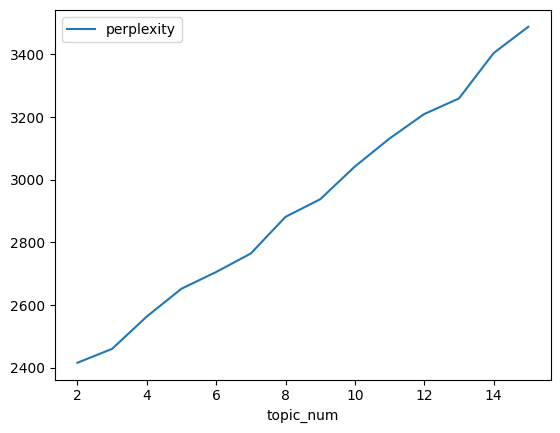

In [63]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

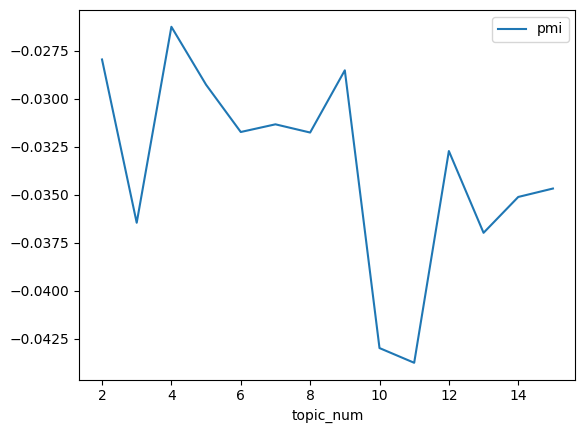

In [64]:
result.plot.line(x='topic_num', y='pmi')

## 3. 視覺化結果

**3.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 4 來做 LDAvis 的結果範例

In [68]:
model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes=5
    )

In [69]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.023025 -0.020126       1        1  56.405851
3      0.034320 -0.019450       2        1  32.037872
0     -0.061659 -0.014554       3        1   5.837616
1      0.004314  0.054130       4        1   5.718661, topic_info=           Term        Freq       Total Category  logprob  loglift
466       could  467.000000  467.000000  Default  30.0000  30.0000
345  mrs_bennet  244.000000  244.000000  Default  29.0000  29.0000
604    mr_darcy  401.000000  401.000000  Default  28.0000  28.0000
236       would  423.000000  423.000000  Default  27.0000  27.0000
599        miss  249.000000  249.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
74         good    7.484726  176.798421   Topic4  -6.0534  -0.3007
108      little    7.457992  174.092631   Topic4  -6.0570  -0.2889
294       every    7.577137  255.594363   Topic4  -6.0412  -0.6570
477       darcy    6.952272  130.176872   Topic4  -6.1272  -0.0684
207       think    6.987244  195.940846   Topic4  -6.1222  -0.4723

[365 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
5911      3  0.732770  abovementioned
3223      1  0.919918        accident
405       1  0.249458    accomplished
405       2  0.124729    accomplished
405       4  0.623645    accomplished
...     ...       ...             ...
236       4  0.054265           would
239       1  0.583171           young
239       2  0.325889           young
239       3  0.025728           young
239       4  0.060032           young

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [70]:
pyLDAvis.save_html(p, "lda_en.html")

## 5. 主題分佈的應用，搭配其他文章資訊

In [71]:
# 取得每章的主題分佈
topics_doc = model.get_document_topics(corpus)

In [83]:
m_theta = corpus2csc(topics_doc).T.toarray()
theta = pd.DataFrame(m_theta, columns=[f"topic_{i+1}" for i in range(m_theta.shape[1])])
theta

,topic_1,topic_2,topic_3,topic_4
0,0.0,0.000000,0.000000,0.997867
1,0.0,0.000000,0.997685,0.000000
2,0.0,0.999028,0.000000,0.000000
3,0.0,0.000000,0.000000,0.997926
4,0.0,0.000000,0.000000,0.998237
...,...,...,...,...
56,0.0,0.000000,0.297625,0.701675
57,0.0,0.000000,0.999240,0.000000
58,0.0,0.000000,0.341968,0.657556
59,0.0,0.000000,0.998882,0.000000


<AxesSubplot:>

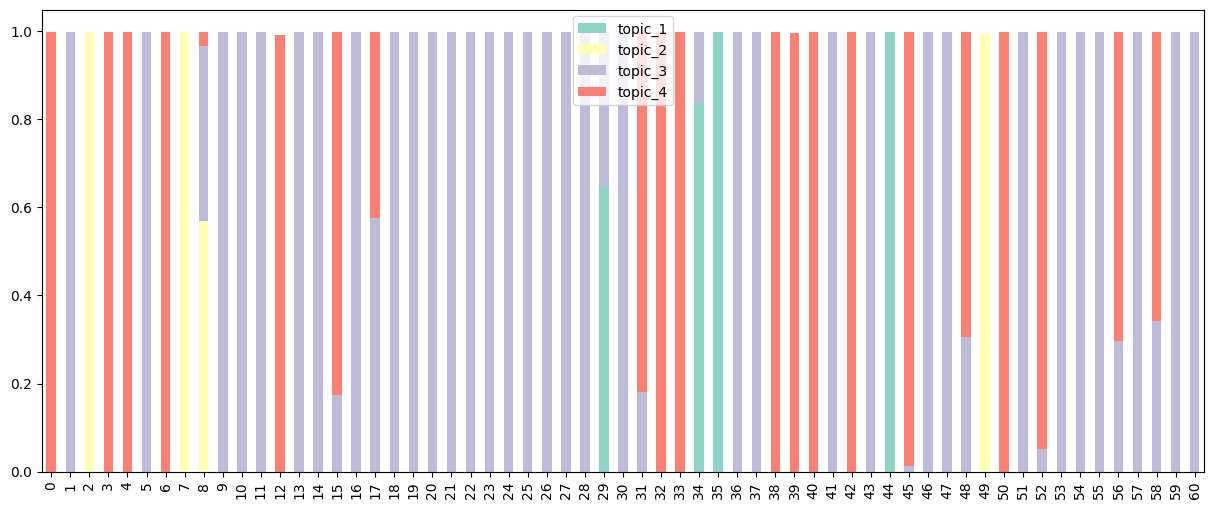

In [84]:
fig, ax = plt.subplots(figsize=(15, 6))
theta.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)